# Create Grid to Neighbor Mapping

In [59]:
import pandas as pd  # provides interface for interacting with tabular data
import geopandas as gpd  # combines the capabilities of pandas and shapely for geospatial operations
from shapely.geometry import Point, Polygon, MultiPolygon  # for manipulating text data into geospatial shapes
from shapely import wkt  # stands for "well known text," allows for interchange across GIS programs
import rtree  # supports geospatial join
import os
import fnmatch
import numpy as np
import matplotlib.pyplot as plt
import descartes
import sys
import sklearn
import math
from datetime import datetime as dt
sys.path.append('C:\\Users\\jades\\1001 Intro to Data Science Notebooks\\Project\\wildfires-1001\\code\\functions')
from gis_processing import *

import warnings
warnings.simplefilter('ignore')

pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [20]:
gitdir = 'C:/Users/jades/1001 Intro to Data Science Notebooks/Project/wildfires-1001/'

In [131]:
#Import grid data
subdir_from = 'data/clean_data/county_grid/'
filename_from = 'county_grid.shp'

county_grid_map = gpd.read_file(gitdir + subdir_from + filename_from)

county_grid_map = county_grid_map.to_crs(crs='epsg:4326')

In [132]:

county_grid_map['key'] = 1
county_grid_map['centroid'] = county_grid_map.centroid
county_grid_map['lat'] = county_grid_map.centroid.y
county_grid_map['long'] = county_grid_map.centroid.x

county_grid_map_cross = county_grid_map.merge(county_grid_map, how='outer', on='key')

county_grid_map_cross['distance'] = ((county_grid_map_cross['lat_x']-county_grid_map_cross['lat_y'])**2 + (county_grid_map_cross['long_x']-county_grid_map_cross['long_y'])**2)**(1/2)

In [133]:
#Create the mapping of each grid ID (GRID_ID_x) to its neighbors (GRID_ID_y)
distance_thresh = 0.85 #Through iteration, this was the distance that captures the 8 surrounding grids

neighbor_map = county_grid_map_cross[(county_grid_map_cross['distance'] > 0) & (county_grid_map_cross['distance'] < distance_thresh)][['GRID_ID_x', 'GRID_ID_y', 'distance']]

In [134]:
#Create feature for the count of nearby grids and a multiplier that is 8 over the count (to normalize edge grids)
nearby_count = neighbor_map.groupby(neighbor_map['GRID_ID_x']).count()['GRID_ID_y']

neighbor_map = neighbor_map.merge(nearby_count, how='left', on='GRID_ID_x')

neighbor_map['multiplier'] = 8/neighbor_map['GRID_ID_y_y']

neighbor_map = neighbor_map.drop(['distance', 'GRID_ID_y_y'], axis=1)
neighbor_map = neighbor_map.rename(columns={"GRID_ID_x": "GRID_ID", "GRID_ID_y_x": "GRID_ID_adj"})

In [136]:
#Save the mapping df
subdir_to = 'data/clean_data/mapping_tables/'
filename_to = 'grid_neighbor_map.csv'
neighbor_map.to_csv(gitdir + subdir_to + filename_to, index=False)

## Visualize/Validate

In [108]:
#Visualize nearest neighbors (1/2)
grid = 52 #Input the grid value you want to check

county_grid_map_cross[(county_grid_map_cross['distance'] > 0) & (county_grid_map_cross['distance'] < 0.85) & (county_grid_map_cross['GRID_ID_x'] == grid)][['GRID_ID_x', 'GRID_ID_y', 'distance']]

,GRID_ID_x,GRID_ID_y,distance
673,52.0,39.0,0.637804
674,52.0,40.0,0.810995
676,52.0,53.0,0.500918
684,52.0,67.0,0.637804
685,52.0,68.0,0.810995
713,52.0,38.0,0.808863
714,52.0,51.0,0.497460
715,52.0,66.0,0.808863


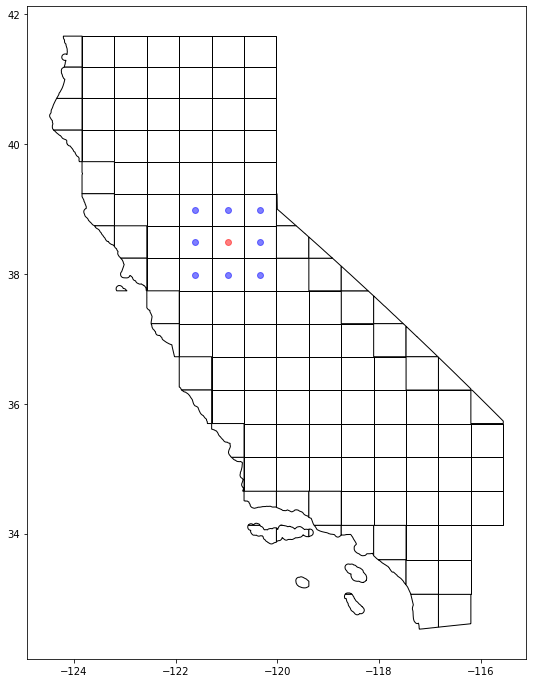

In [109]:
#Plot (2/2)
neighbors = [39,40,53,67,68,38,51,66] #Copy the GRID_ID_y values above into this list and plot

ax = county_grid_map.plot(color = 'white', edgecolor = 'black', figsize = (12,12))
county_grid_map[county_grid_map['GRID_ID'].isin([grid])]['centroid'].plot(ax=ax, color = 'red', alpha = 0.5, figsize = (12,12))
county_grid_map[county_grid_map['GRID_ID'].isin(neighbors)]['centroid'].plot(ax=ax, color = 'blue', alpha = 0.5, figsize = (12,12))